## **1. Google Drive**

In [202]:
#from google.colab import drive
#drive.mount('/content/drive')
#cur_dir = "/content/drive/MyDrive/CH2/Notebooks"
#%cd $cur_dir


In [203]:
#%pip install torchview


## **2. Import Libraries**

In [204]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph
from scipy import ndimage
from PIL import Image
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms as tfs
import math

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path
import shutil
import gc
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import torch.nn.functional as F

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.8.0+cu128
Device: cuda


## **3. Config and  Helper Functions**

### 3.1 Config

In [205]:
USE_MASKED_PATCHES = False

In [206]:
datasets_path = os.path.join(os.path.pardir, "an2dl2526c2")

train_data_path = os.path.join(datasets_path, "train_data")
train_labels_path = os.path.join(datasets_path, "train_labels.csv")
test_data_path = os.path.join(datasets_path, "test_data")

CSV_PATH = train_labels_path                # Path to the CSV file with labels
SOURCE_FOLDER = train_data_path

if USE_MASKED_PATCHES:
  PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results_masked","train_patches_masked")
  SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results_masked","submission_patches_masked")
else:
  PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","train_patches")
  SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","submission_patches")
SUBMISSION_PATCH_MASKS = os.path.join(datasets_path, "preprocessing_results","submission_patches","masks")
BLURRED_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","train_patches_blurred")

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Patches output path: {PATCHES_OUT}")
print(f"Submission patches output path: {SUBMISSION_PATCHES_OUT}")
print(f"Submission patch masks path: {SUBMISSION_PATCH_MASKS}")


# Define where your Ground Truth binary masks are stored
# Assuming filenames match: img_001.png -> mask_001.png (or similar)
MASKS_DIR = os.path.join(datasets_path, "preprocessing_results", "train_patches", "masks")

# ImageNet normalization statistics
IMAGENET_MEAN = [float(x) for x in [0.485, 0.456, 0.406]]  # or convert your current values to float
IMAGENET_STD  = [float(x) for x in [0.229, 0.224, 0.225]]



TARGET_SIZE = (224, 224)                    # Target size for the resized images and masks

Dataset path: ../an2dl2526c2
Train data path: ../an2dl2526c2/train_data
Train labels path: ../an2dl2526c2/train_labels.csv
Test data path: ../an2dl2526c2/test_data
Patches output path: ../an2dl2526c2/preprocessing_results/train_patches
Submission patches output path: ../an2dl2526c2/preprocessing_results/submission_patches
Submission patch masks path: ../an2dl2526c2/preprocessing_results/submission_patches/masks


### 3.2 Helper Functions

In [207]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from torchvision import transforms
from PIL import Image

def plot_sample_with_predictions(model, loader, device, label_encoder, sample_id=None, aggregation_method='max_confidence'):
    """
    Plot all patches of a single sample and the aggregated image prediction.
    (Updated for Paired Image / Two-Stream Models)
    """
    model.eval()
    
    # 1. Robust Dataset Access
    dataset = loader.dataset
    while hasattr(dataset, 'dataset'): # Unwrap Subsets
        dataset = dataset.dataset
    
    df = dataset.df
    
    # <--- CHANGED: Retrieve target_dir
    target_dir = getattr(dataset, 'target_dir', None)

    # 2. Pick a sample_id
    if sample_id is None:
        sample_id = np.random.choice(df['sample_id'].unique())
    
    # Get all patches for this sample
    sample_patches = df[df['sample_id'] == sample_id].reset_index(drop=True)
    print(f"Visualizing Sample ID: {sample_id} ({len(sample_patches)} patches)")

    # 3. Define Transforms
    # <--- CHANGED: Use the same transform (Resize+Norm) for BOTH images
    inference_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # 4. Load Data
    images_tensors = []
    targets_tensors = [] # <--- Renamed from masks_tensors
    display_imgs = []
    
    # Stats for denormalization (Display only)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    for _, row in sample_patches.iterrows():
        try:
            # --- A. Load Input Image ---
            img_path = row['path']
            # Handle if full path or relative
            if hasattr(dataset, 'img_dir') and dataset.img_dir:
                 img_path = os.path.join(dataset.img_dir, img_path)

            img = Image.open(img_path).convert('RGB')
            tensor_img = inference_transform(img)
            images_tensors.append(tensor_img)
            
            # Create Display Image (Denormalize -> Clamp -> Numpy)
            disp_img = torch.clamp(tensor_img * std + mean, 0, 1)
            display_imgs.append(disp_img)
            
            # --- B. Load Target Image ---
            # <--- CHANGED: Load second image based on filename match
            if target_dir:
                filename = os.path.basename(img_path)
                target_path = os.path.join(target_dir, filename)
                
                if os.path.exists(target_path):
                    target = Image.open(target_path).convert('RGB')
                else:
                    target = Image.new('RGB', (224, 224), (0, 0, 0))
            else:
                target = Image.new('RGB', (224, 224), (0, 0, 0))
            
            # <--- CHANGED: Normalize the target too
            tensor_target = inference_transform(target)
            targets_tensors.append(tensor_target)

        except Exception as e:
            print(f"Error loading {row['path']}: {e}")
            continue

    if not images_tensors:
        print("No valid images found for this sample.")
        return

    # 5. Batch Inference
    batch_imgs = torch.stack(images_tensors).to(device)
    batch_targets = torch.stack(targets_tensors).to(device)
    
    with torch.no_grad():
        # --- FIX: Pass BOTH image batches ---
        logits = model(batch_imgs, batch_targets) 
        probs = torch.softmax(logits, dim=1).cpu()

    # 6. Process Predictions
    patch_preds = probs.argmax(dim=1).numpy()
    patch_confs = probs.max(dim=1).values.numpy()

    # --- Aggregation Logic ---
    if aggregation_method == 'max_confidence':
        image_probs = probs.mean(dim=0).numpy()
        image_pred = image_probs.argmax()
        image_conf = image_probs[image_pred]
    elif aggregation_method == 'majority_voting':
        counts = np.bincount(patch_preds, minlength=len(label_encoder.classes_))
        image_pred = counts.argmax()
        image_probs = counts / counts.sum()
        image_conf = image_probs[image_pred]
    else:
        raise ValueError(f"Unknown aggregation method: {aggregation_method}")

    # Labels
    image_pred_label = label_encoder.inverse_transform([image_pred])[0]
    true_label_idx = sample_patches.iloc[0]['label_encoded']
    true_label = label_encoder.inverse_transform([true_label_idx])[0]

    # 7. Plotting
    cols = min(6, len(sample_patches))
    rows = math.ceil(len(sample_patches) / cols)
    
    fig = plt.figure(figsize=(3*cols + 4, 3*rows))
    gs = fig.add_gridspec(rows, cols + 1, width_ratios=[1]*cols + [1.3])

    # Patch grid
    for idx, (img_disp, pred, conf) in enumerate(zip(display_imgs, patch_preds, patch_confs)):
        ax = fig.add_subplot(gs[idx // cols, idx % cols])
        
        # Note: We display the INPUT image. 
        # If you want to see the target, you'd need a more complex plot (e.g., side-by-side).
        ax.imshow(img_disp.permute(1,2,0))
        
        lbl = label_encoder.inverse_transform([pred])[0]
        color = 'green' if pred == image_pred else 'red'
        
        # Title shows Patch Prediction
        ax.set_title(f"{lbl}\n{conf:.2%}", fontsize=9, color='black', backgroundcolor='white')
        ax.axis('off')

    # Aggregated Bar Chart
    ax_bar = fig.add_subplot(gs[:, -1])
    class_names = label_encoder.classes_
    colors = ['green' if i == image_pred else 'lightgray' for i in range(len(class_names))]
    
    y_pos = np.arange(len(class_names))
    ax_bar.barh(y_pos, image_probs, color=colors)
    ax_bar.set_yticks(y_pos)
    ax_bar.set_yticklabels(class_names)
    ax_bar.invert_yaxis()
    
    ax_bar.set_xlabel('Probability' if aggregation_method == 'max_confidence' else 'Vote Share')
    ax_bar.set_xlim([0,1])
    
    ax_bar.set_title(f"Sample: {sample_id}\nTrue: {true_label}\nPred: {image_pred_label} ({image_conf:.2%})\n{aggregation_method}")
    
    for i, prob in enumerate(image_probs):
        ax_bar.text(prob + 0.02, i, f"{prob:.3f}", va='center')

    plt.tight_layout()
    plt.show()

In [250]:
import torch
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm

def get_image_predictions(model, loader, device, method='max_mean_confidence'):
    """
    Aggregates patch-level predictions to image-level for Two-Stream (Paired Image) models.
    """
    model.eval()

    valid_methods = { "max_mean_confidence", "max_confidence"}
    if method not in valid_methods:
        raise ValueError(f"Unknown method '{method}'. Choose from {valid_methods}.")

    # 1. Robustly retrieve the underlying dataset
    dataset = loader.dataset
    while hasattr(dataset, 'dataset'):
        dataset = dataset.dataset
        
    df = dataset.df
    
    # <--- CHANGED: Retrieve target_dir instead of masks_location
    target_dir = getattr(dataset, 'target_dir', None)


    # 2. Define Transforms
    # <--- CHANGED: We now use the SAME transform for both images 
    # (Resize + ToTensor + ImageNet Normalization)
    inference_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    y_true = []
    y_pred = []
    
    sample_ids = df['sample_id'].unique()

    for sample_id in tqdm(sample_ids, leave=False):
        # Get all patches for this whole-slide image
        sample_patches = df[df['sample_id'] == sample_id]

        # Ground Truth
        true_label = sample_patches.iloc[0]['label_encoded']
        y_true.append(true_label)

        patches_img = []
        patches_target = [] # <--- Renamed from patches_mask

        for img_path in sample_patches['path']:
            try:
                # --- A. Load Input Image ---
                img = Image.open(img_path).convert('RGB')
                img = inference_transform(img)
                
                # --- B. Load Second Image (Target) ---
                if target_dir:
                    # <--- CHANGED: Logic = target_dir + same filename
                    filename = os.path.basename(img_path)
                    target_path = os.path.join(target_dir, filename)
                    
                    if os.path.exists(target_path):
                        # <--- CHANGED: Load as RGB
                        target = Image.open(target_path).convert('RGB')
                    else:
                        # Fallback: Black RGB image
                        target = Image.new('RGB', (224, 224), (0, 0, 0))
                else:
                    target = Image.new('RGB', (224, 224), (0, 0, 0))
                
                # <--- CHANGED: Apply the same normalization transform to the target
                target = inference_transform(target)
                
                patches_img.append(img)
                patches_target.append(target)

            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue

        if not patches_img:
            y_pred.append(true_label) # Fallback if all patches fail
            continue

        # Stack batch
        batch_imgs = torch.stack(patches_img).to(device)
        batch_targets = torch.stack(patches_target).to(device)

        with torch.no_grad():
            # --- Pass BOTH Images ---
            # Ensure your model's forward method accepts (x1, x2)
            logits = model(batch_imgs, batch_targets)
            
            # Softmax to get probabilities
            probs = torch.softmax(logits, dim=1)
            if method == "max_mean_confidence":
                # Average pooling of probabilities (standard for WSI classification)
                avg_probs = torch.mean(probs, dim=0)
                pred_label = torch.argmax(avg_probs).item()
            elif method == "max_confidence":
                # Max confidence pooling
                pred_label = torch.argmax(probs.max(dim=0).values).item()

            # Average pooling of probabilities (standard for WSI classification)
            avg_probs = torch.mean(probs, dim=0)
            pred_label = torch.argmax(avg_probs).item()

        y_pred.append(pred_label)

    return y_true, y_pred



In [209]:
# Create a simple function to handle this
def print_model_stats(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")

## **4. Train/Val Split**

In [210]:
def create_metadata_dataframe(patches_dir, labels_csv_path):
    """
    Creates a DataFrame mapping patch filenames to their Bag IDs and Labels.
    """
    # 1. Load the labels CSV
    # Assuming CSV structure: [image_id, label] or similar
    df_labels = pd.read_csv(labels_csv_path)

    # Standardize column names for easier merging
    # We assume the first column is the ID and the second is the Label
    id_col = df_labels.columns[0]
    label_col = df_labels.columns[1]

    # Ensure IDs in CSV are strings (to match filenames)
    df_labels[id_col] = df_labels[id_col].astype(str)

    # If the CSV IDs contain extensions (e.g., 'img_001.png'), remove them
    # because our parsed Bag IDs won't have them.
    df_labels[id_col] = df_labels[id_col].apply(lambda x: os.path.splitext(x)[0])

    # 2. List all patch files
    patch_files = [f for f in os.listdir(patches_dir) if f.endswith('.png')]

    # 3. Parse filenames to get Bag IDs
    data = []
    print(f"Found {len(patch_files)} patches. Parsing metadata...")

    for filename in patch_files:
        # Expected format from your preprocessing: {base_name}_p{i}.png
        # Example: "img_0015_p12.png" -> Bag ID should be "img_0015"

        # Split from the right on '_p' to separate Bag ID from Patch Index
        # "img_0015_p12.png" -> ["img_0015", "12.png"]
        try:
            bag_id = filename.rsplit('_p', 1)[0]

            data.append({
                'filename': filename,
                'sample_id': bag_id,
                'path': os.path.join(patches_dir, filename)
            })
        except IndexError:
            print(f"Skipping malformed filename: {filename}")

    # Create temporary patches DataFrame
    df_patches = pd.DataFrame(data)

    # 4. Merge patches with labels
    # This assigns the correct Bag Label to every Patch in that Bag
    df = pd.merge(df_patches, df_labels, left_on='sample_id', right_on=id_col, how='inner')

    # 5. Clean up and Rename
    # Keep only required columns
    df = df[['filename', label_col, 'sample_id', 'path']]

    # Rename label column to standard 'label' if it isn't already
    df = df.rename(columns={label_col: 'label'})

    print(f"Successfully created DataFrame with {len(df)} rows.")
    return df

In [211]:
patches_metadata_df = create_metadata_dataframe(PATCHES_OUT, CSV_PATH)

# Verify the result
print("\nFirst 5 rows:")
print(patches_metadata_df.head().drop(columns=['path']))
print("\nPatches per Bag (Distribution):")
print(patches_metadata_df['sample_id'].value_counts().describe())

Found 2788 patches. Parsing metadata...
Successfully created DataFrame with 2788 rows.

First 5 rows:
          filename      label sample_id
0  img_0690_p2.png  Luminal A  img_0690
1  img_0690_p1.png  Luminal A  img_0690
2  img_0690_p0.png  Luminal A  img_0690
3  img_0689_p3.png  Luminal A  img_0689
4  img_0689_p2.png  Luminal A  img_0689

Patches per Bag (Distribution):
count    631.000000
mean       4.418384
std        2.771610
min        1.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       23.000000
Name: count, dtype: float64


In [212]:
# Add Label Encoding
print("\n" + "="*50)
print("Label Encoding")
print("="*50)

label_encoder = LabelEncoder()
patches_metadata_df['label_encoded'] = label_encoder.fit_transform(patches_metadata_df['label'])

print(f"\nOriginal Labels: {label_encoder.classes_}")
print(f"Encoded as: {list(range(len(label_encoder.classes_)))}")
print(f"\nLabel Mapping:")
for orig, enc in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"  {orig} -> {enc}")


Label Encoding

Original Labels: ['HER2(+)' 'Luminal A' 'Luminal B' 'Triple negative']
Encoded as: [0, 1, 2, 3]

Label Mapping:
  HER2(+) -> 0
  Luminal A -> 1
  Luminal B -> 2
  Triple negative -> 3


In [213]:
# Train/Val/Test Split on Original Images (not patches)
print("\n" + "="*50)
print("Train/Val/Test Split on Original Images")
print("="*50)

# 1. Get unique sample IDs and their corresponding labels for stratification
unique_samples = patches_metadata_df['sample_id'].unique()
sample_labels = patches_metadata_df.drop_duplicates('sample_id').set_index('sample_id').loc[unique_samples, 'label_encoded']

print(f"\nTotal unique samples (original images): {len(unique_samples)}")

# 2. First Split: Train (80%) vs Temp (20%)
train_samples, temp_samples, y_train, y_temp = train_test_split(
    unique_samples,
    sample_labels,
    test_size=0.2,
    random_state=SEED,
    stratify=sample_labels
)

# 3. Second Split: Split Temp (20%) into Val (10%) and Test (10%)
# We split the temp set by 0.5 to get equal halves
val_samples, test_samples = train_test_split(
    temp_samples,
    test_size=0.5,
    random_state=SEED,
    stratify=y_temp
)

print(f"Train samples: {len(train_samples)}")
print(f"Val samples:   {len(val_samples)}")
print(f"Test samples:  {len(test_samples)}")

# 4. Create DataFrames by filtering patches based on the ID lists
df_train = patches_metadata_df[patches_metadata_df['sample_id'].isin(train_samples)].reset_index(drop=True)
df_val = patches_metadata_df[patches_metadata_df['sample_id'].isin(val_samples)].reset_index(drop=True)
df_test = patches_metadata_df[patches_metadata_df['sample_id'].isin(test_samples)].reset_index(drop=True)

# 5. Print Statistics
print(f"\nTrain patches: {len(df_train)}")
print(f"Val patches:   {len(df_val)}")
print(f"Test patches:  {len(df_test)}")

print(f"\nTrain label distribution:\n{df_train['label'].value_counts()}")
print(f"\nVal label distribution:\n{df_val['label'].value_counts()}")
print(f"\nTest label distribution:\n{df_test['label'].value_counts()}")

# Print percentage distribution
print(f"\n" + "="*50)
print("Percentage Distribution")
print("="*50)
print(f"\nTrain label percentage:\n{df_train['label'].value_counts(normalize=True) * 100}")
print(f"\nVal label percentage:\n{df_val['label'].value_counts(normalize=True) * 100}")
print(f"\nTest label percentage:\n{df_test['label'].value_counts(normalize=True) * 100}")


Train/Val/Test Split on Original Images

Total unique samples (original images): 631
Train samples: 504
Val samples:   63
Test samples:  64

Train patches: 2214
Val patches:   302
Test patches:  272

Train label distribution:
label
Luminal B          763
Luminal A          631
HER2(+)            618
Triple negative    202
Name: count, dtype: int64

Val label distribution:
label
Luminal B          115
HER2(+)             77
Luminal A           66
Triple negative     44
Name: count, dtype: int64

Test label distribution:
label
Luminal B          86
Luminal A          73
HER2(+)            72
Triple negative    41
Name: count, dtype: int64

Percentage Distribution

Train label percentage:
label
Luminal B          34.462511
Luminal A          28.500452
HER2(+)            27.913279
Triple negative     9.123758
Name: proportion, dtype: float64

Val label percentage:
label
Luminal B          38.079470
HER2(+)            25.496689
Luminal A          21.854305
Triple negative    14.569536
Name

## **5. Transformations & Augmentation**

In [214]:
# Define augmentation for training with enhanced transformations
train_augmentation = transforms.Compose([
    # Geometric transformations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),  # Small rotations to handle orientation variations
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),  # Reduced from 0.2 for more conservative shifts
        scale=None,  # Add scale variation
        shear=10  # Add shear transformation
    ),

    # Color/appearance transformations
    transforms.ColorJitter(
        brightness=0.2,  # Adjust brightness
        contrast=0.2,    # Adjust contrast
        saturation=0.2,  # Adjust saturation
        hue=0.1          # Slight hue variation
    ),
    #transforms.RandomGrayscale(p=0.1),  # Occasionally convert to grayscale to improve robustness

    # Occlusion simulation
    #transforms.RandomErasing(
    #    p=0.3,  # Reduced probability for more balanced augmentation
    #    scale=(0.02, 0.15),  # Reduced max scale
    #    ratio=(0.3, 3.3)  # Aspect ratio range
    #),

    # Optional: Add Gaussian blur for noise robustness
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
])

train_augmentation = transforms.Compose([
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET),
    transforms.RandomHorizontalFlip(p=0.5)
])

## **6. Custom Dataset Class**

In [ ]:
import torch
import torchvision.transforms.functional as TF
import os
import random
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class PairedTissueDataset(Dataset):
    def __init__(self, df, img_dir=None, target_dir=None, transform=None, target_size=(224, 224), label_col='label_encoded'):
        """
        Args:
            df: DataFrame containing the first image paths.
            img_dir: (Optional) Root dir to prepend to df paths.
            target_dir: Root directory where the SECOND images are located.
            transform: A torchvision.transforms object (e.g. Compose) to apply to both images.
            target_size: Tuple (height, width) to resize images to BEFORE augmentation.
        """
        self.df = df
        self.img_dir = img_dir
        self.target_dir = target_dir
        self.transform = transform
        self.target_size = target_size
        self.label_col = label_col

        # Standard Normalization (Applied individually after the synced transform)
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # --- A. Load Input Image ---
        img_path = row['path']
        if self.img_dir:
            img_path = os.path.join(self.img_dir, img_path)
            
        image = Image.open(img_path).convert("RGB")
        
        # --- B. Load Target Image ---
        filename = os.path.basename(img_path)
        
        if self.target_dir:
            target_path = os.path.join(self.target_dir, filename)
            if os.path.exists(target_path):
                target_image = Image.open(target_path).convert("RGB")
            else:
                target_image = Image.new('RGB', image.size, (0, 0, 0))
        else:
            raise ValueError("target_dir must be provided.")

        # --- C. Resize (Deterministic) ---
        image = TF.resize(image, self.target_size)
        target_image = TF.resize(target_image, self.target_size)

        # --- D. SYNCHRONIZED AUGMENTATION (The "State Replay" Trick) ---
        if self.transform:
            # 1. Save the current random states
            # We save both Python's random and PyTorch's random states 
            # to ensure complete synchronization across different transform types.
            state_random = random.getstate()
            state_torch = torch.get_rng_state()

            # 2. Apply to Input Image
            image = self.transform(image)

            # 3. Restore the random states exactly as they were
            random.setstate(state_random)
            torch.set_rng_state(state_torch)

            # 4. Apply to Target Image
            # Because the RNG state is reset, the transform will make the 
            # EXACT same random choices (same crop, same flip, same autoaugment policy)
            target_image = self.transform(target_image)

        # --- E. To Tensor ---
        if not isinstance(image, torch.Tensor):
            image = TF.to_tensor(image)
        if not isinstance(target_image, torch.Tensor):
            target_image = TF.to_tensor(target_image)

        # --- F. Normalization ---
        # We normalize independently because this is a deterministic pixel operation
        image = self.normalize(image)
        target_image = self.normalize(target_image)

        # --- G. Return ---
        label = torch.tensor(row[self.label_col], dtype=torch.long)
        
        return image, label, target_image

## **7. Data Loaders**

In [244]:
# Instantiate Datasets
train_dataset = PairedTissueDataset(df_train, transform=train_augmentation,  target_dir=BLURRED_PATCHES_OUT   )
val_dataset = PairedTissueDataset(df_val, transform=None,  target_dir=BLURRED_PATCHES_OUT   )
test_dataset = PairedTissueDataset(df_test, transform=None,  target_dir=BLURRED_PATCHES_OUT )

# Batch Size: 32 or 64 is standard for ResNet18/50 on 1MP images
BATCH_SIZE = 64

cpu_cores = os.cpu_count() or 2
num_workers = cpu_cores//2
# Instantiate Loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,          # Shuffle patches to break batch correlations
    num_workers=num_workers,         # Adjust based on your CPU
    pin_memory=True        # Faster data transfer to CUDA
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,         # No need to shuffle validation
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,         # No need to shuffle test
    num_workers=num_workers,
    pin_memory=True
)

print(f"Train Loader: {len(train_loader)} batches")
print(f"Val Loader: {len(val_loader)} batches")
print(f"Num workers: {train_loader.num_workers}")

Train Loader: 35 batches
Val Loader: 5 batches
Num workers: 24



Visualizing Training Batch (Augmented):


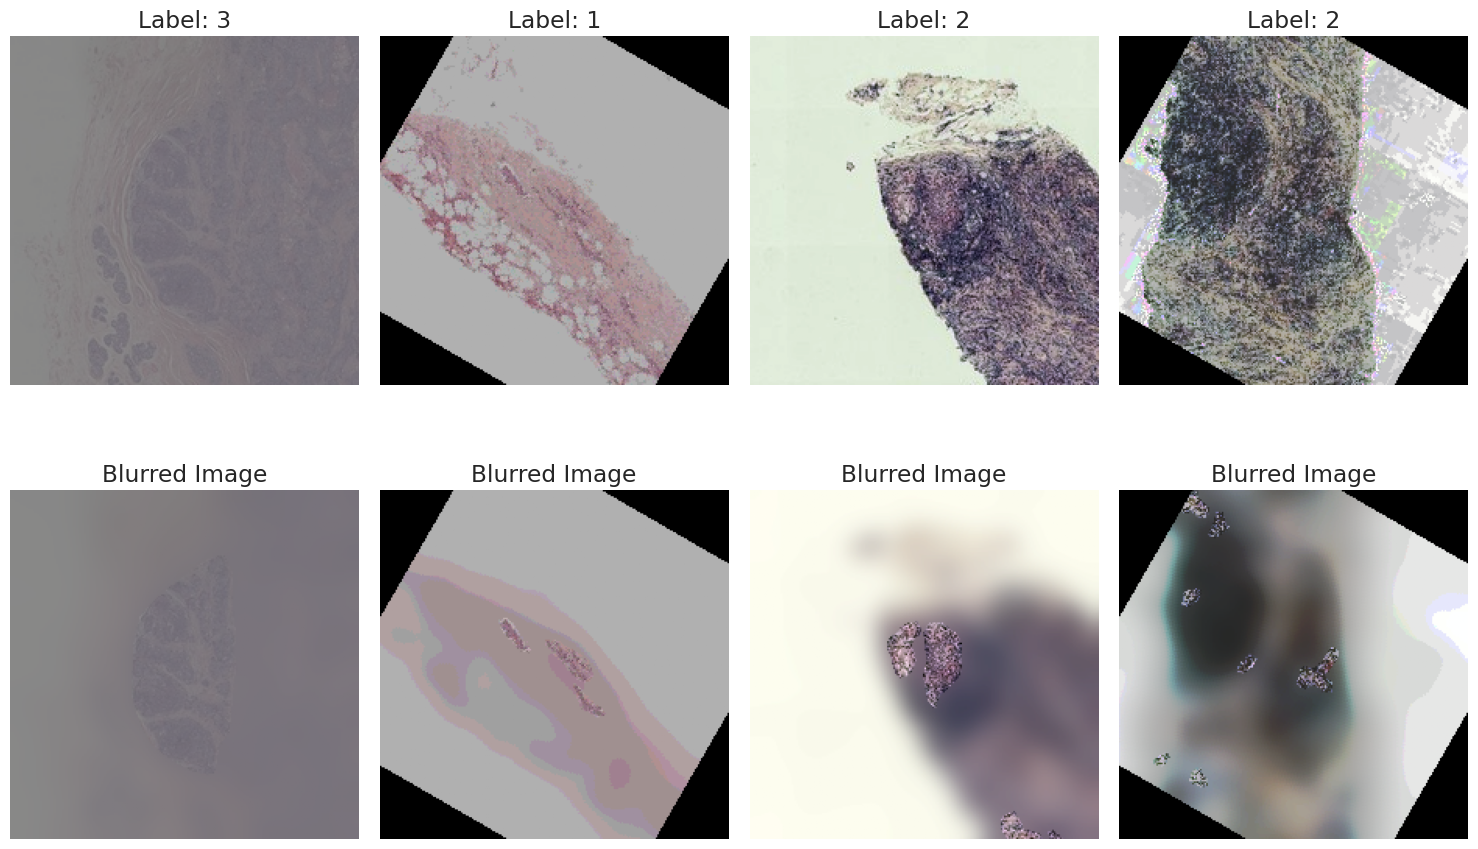

In [217]:
def show_batch(loader, count=4):
    # 1. Robust Unpacking
    # The loader might return 2 items (Image, Label) or 3 (Image, Label, Mask)
    batch = next(iter(loader))
    images, labels = batch[0], batch[1]
    masks = batch[2] if len(batch) > 2 else None

    # Determine layout: 1 row if no masks, 2 rows if masks exist
    nrows = 2 if masks is not None else 1
    plt.figure(figsize=(15, 5 * nrows))

    # Denormalize for visualization (ImageNet stats)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i in range(count):
        # --- Plot Image ---
        ax = plt.subplot(nrows, count, i + 1)
        
        img = images[i]
        img = img * std + mean  # Un-normalize
        img = torch.clamp(img, 0, 1)  # Clip to valid range
        
        plt.imshow(img.permute(1, 2, 0)) # CHW -> HWC
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")

        # --- Plot Mask (if available) ---
        if masks is not None:
            ax = plt.subplot(nrows, count, i + 1 + count) # Second row
            mask = masks[i]
            mask = mask * std + mean  # Un-normalize
            mask = torch.clamp(mask, 0, 1)  # Clip to valid range
            
            plt.imshow(mask.permute(1, 2, 0)) # CHW -> HWC
            plt.title("Blurred Image")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

print("\nVisualizing Training Batch (Augmented):")
show_batch(train_loader)

## **8. Hyperparameters**

In [218]:
NUM_EPOCHS_TL = 5  
NUM_EPOCHS_FT = 200

PATIENCE = 6 




L2_REG = 1e-4
LR_TL = 1e-3
LR_FT = 1e-4

# --- Configuration ---
# How many blocks to unfreeze from the end of each backbone?
# 0 = Frozen, 1 = Last Block, 2 = Last 2 Blocks, etc.
UNFREEZE_LAYERS_IMG = 2  # For ResNet50 (The Color Stream)
UNFREEZE_LAYERS_MASK = 2  # For ResNet18 (The Geometry Stream)


## **9. Model Definition: Parallel - ResNet50 + ResNet18**

In [219]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetParallel(nn.Module):
    def __init__(self, 
                 num_classes=4, 
                 freeze_backbone=False,
                 dropout_rate=0.3,):
        super(ResNetParallel, self).__init__()
        
        # --- Pillar 1: The Color Stream (RGB Image) ---
        # We use ResNet50 for the complex texture features
        img_resnet = models.resnet50(weights='DEFAULT')
        
        # Remove the Classification Head (fc) and avgpool
        # We want the spatial features or the flattened vector before the final layer
        # Here we take the layers up to the final pooling
        self.img_encoder = nn.Sequential(*list(img_resnet.children())[:-1])
        img_out_dim = 2048 # ResNet50 output size
        
        # --- Pillar 2: The Geometry Stream (Mask) ---
        # We use ResNet18 for the mask (shapes are simpler than textures)
        mask_resnet = models.resnet50(weights='DEFAULT')
        
        
        # Remove head
        self.mask_encoder = nn.Sequential(*list(mask_resnet.children())[:-1])
        mask_out_dim = 2048 # ResNet50 output size
        
        # --- Freeze Logic (Optional) ---
        if freeze_backbone:
            for param in self.img_encoder.parameters():
                param.requires_grad = False
            for param in self.mask_encoder.parameters():
                param.requires_grad = False

        # --- The Summit: Fusion & Classification ---
        # We concatenate the two vectors: 2048 (Image) + 512 (Mask) = 2560
        fusion_dim = img_out_dim + mask_out_dim
        
        self.classifier = nn.Sequential(
            # Block 1: Compression & Non-Linearity
            nn.Linear(fusion_dim, 896),
            nn.BatchNorm1d(896),
            nn.GELU(),              # Modern activation (better than ReLU)
            nn.Dropout(p=dropout_rate+0.1),      # High dropout to force robust features
            
            # Block 2: Refinement
            nn.Linear(896, 896//2),
            nn.BatchNorm1d(896//2),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),
            
            # Block 3: Final Decision
            nn.Linear(896//2, num_classes)
        )
    def _init_weights(self, module):
        for m in module.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, img, mask):
        # 1. Walk the Path of Color
        # img shape: [Batch, 3, 224, 224] -> [Batch, 2048, 1, 1]
        img_feat = self.img_encoder(img)
        img_feat = torch.flatten(img_feat, 1) # [Batch, 2048]
        
        # 2. Walk the Path of Geometry
        # mask shape: [Batch, 1, 224, 224] -> [Batch, 512, 1, 1]
        mask_feat = self.mask_encoder(mask)
        mask_feat = torch.flatten(mask_feat, 1) # [Batch, 512]
        
        # 3. The Fusion (Meet at the Summit)
        combined_feat = torch.cat((img_feat, mask_feat), dim=1) # [Batch, 2560]
        
        # 4. Final Decision
        logits = self.classifier(combined_feat)
        
        return logits
    
    def unfreeze(self):
        """Allow the pillars to adapt their foundations."""
        for param in self.img_encoder.parameters():
            param.requires_grad = True
        for param in self.mask_encoder.parameters():
            param.requires_grad = True

In [220]:
# Initialize the model
# Ensure device is defined (usually from previous cells, but safe to redefine if standalone)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming label_encoder is defined in your notebook scope
num_classes = len(label_encoder.classes_)
model = ResNetParallel(num_classes=num_classes,  freeze_backbone=True)
model = model.to(device)

print(f"Model initialized (ResNetParallel) with {num_classes} output classes.")
print_model_stats(model)


Model initialized (ResNetParallel) with 4 output classes.
Total params: 51,093,316
Trainable params: 4,077,252


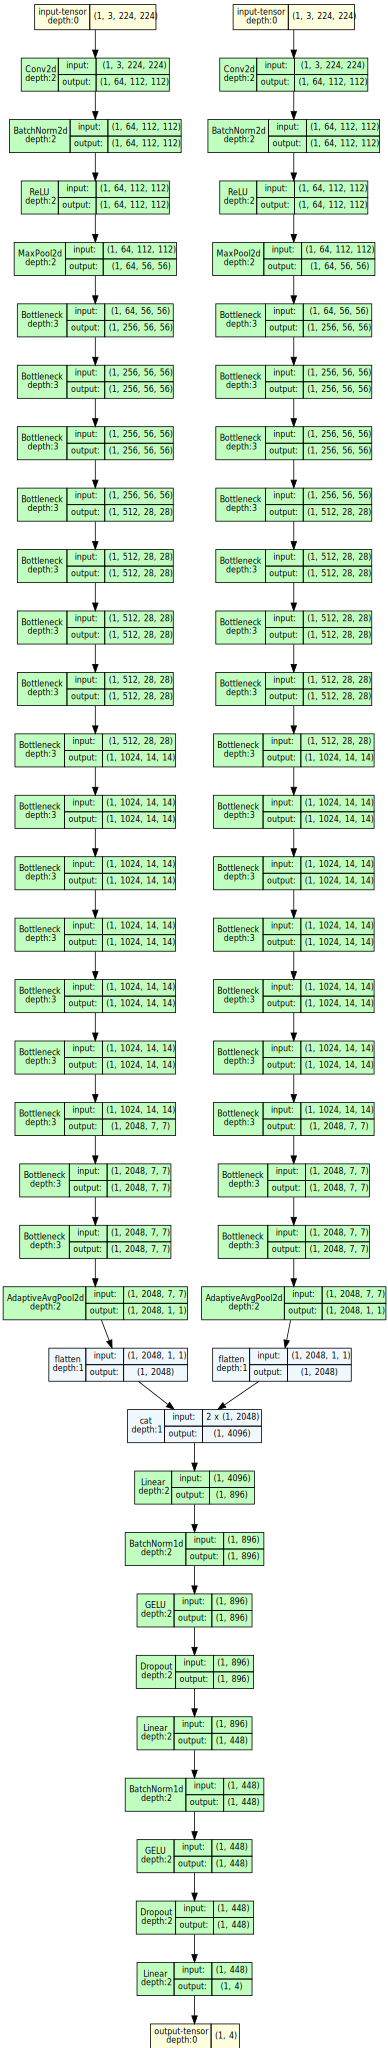

In [221]:
import torchsummary
model_graph = draw_graph(
    model, 
    input_size=[(1, 3, TARGET_SIZE[0], TARGET_SIZE[1]), (1, 3, TARGET_SIZE[0], TARGET_SIZE[1])],
    device=device.type
)
model_graph.visual_graph

## **10. Criterion and Optimizer**

In [222]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        Args:
            alpha (Tensor, optional): Weights for each class. Shape [C].
            gamma (float): Focusing parameter. Higher value = more focus on hard examples.
                           Default is 2.0 (standard from the paper).
            reduction (str): 'mean', 'sum', or 'none'.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: [Batch, C] (Logits)
        # targets: [Batch] (Class Indices)
        
        # 1. Standard Cross Entropy Loss (element-wise, no reduction yet)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # 2. Get the probability of the true class (pt)
        # pt = exp(-ce_loss) because ce_loss = -log(pt)
        pt = torch.exp(-ce_loss)
        
        # 3. Calculate Focal Component: (1 - pt)^gamma
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        # 4. Apply Class Weights (alpha) if provided
        if self.alpha is not None:
            # Gather the alpha value corresponding to the target class for each sample
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        # 5. Reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [223]:
# 1. Get Counts (from your snippet)
class_counts = df_train['label_encoded'].value_counts().sort_index().values
total_samples = sum(class_counts)
n_classes = len(class_counts)

# 2. Define Manual Tuning Factors (The "weight" knob)
# 1.0 = Default (Pure Inverse Frequency)
# > 1.0 = Force model to focus MORE on this class (e.g., critical error)
# < 1.0 = Force model to focus LESS on this class (e.g., noisy label)
# Ensure this list length matches n_classes (4 in your case)
tuning_factors = torch.tensor([1.0, 1.0, 1.0, 0.6], dtype=torch.float32)

# 3. Calculate Base Weights (Standard Inverse Frequency)
# Formula: N / (C * freq)
base_weights = torch.tensor(
    [total_samples / (n_classes * c) for c in class_counts],
    dtype=torch.float32
)

# 4. Apply Tuning
# Final Weight = Inverse_Freq_Weight * Manual_Tuning_Factor
final_weights = base_weights * tuning_factors

# 5. Move to device
final_weights = final_weights.to(device)

print(f"Base Weights:  {base_weights}")
print(f"Tuning Factors:{tuning_factors}")
print(f"Final Weights: {final_weights}")

# --- DEFINING THE LOSS ---
# Gamma=2.0 is the standard starting point.
# If your model is still ignoring the minority class, try Gamma=3.0 or 4.0.
criterion_cls = FocalLoss(alpha=None, gamma=2.0)

# Optimizer 
#optimizer = torch.optim.RAdam(
#    [p for p in model.parameters() if p.requires_grad],
#    lr=LR_TL,
#    betas=(0.9, 0.999),
#    eps=1e-8,
#    weight_decay=L2_REG
#)
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=LR_TL,
    weight_decay=L2_REG
)

Base Weights:  tensor([0.8956, 0.8772, 0.7254, 2.7401])
Tuning Factors:tensor([1.0000, 1.0000, 1.0000, 0.6000])
Final Weights: tensor([0.8956, 0.8772, 0.7254, 1.6441], device='cuda:0')


## **11. Function: Training & Validation Loop**

In [224]:
from sklearn.metrics import f1_score
import numpy as np

def calculate_metrics(preds, targets):
    # Move to CPU and convert to numpy
    preds = preds.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    # Calculate Macro F1 (balanced for all classes)
    return f1_score(targets, preds, average='macro')

In [225]:
def train_one_epoch(model, loader, criterion_cls, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    loop = tqdm(loader, desc="Training", leave=False)
    
    for images, labels, masks in loop:
        images, labels, masks = images.to(device), labels.to(device), masks.to(device)
        
        optimizer.zero_grad()
        
        # --- FIX 1: Pass BOTH Image and Mask ---
        # The model "fuses" them to produce a single classification result
        logits = model(images, masks) 
        
        # --- FIX 2: Classification Loss Only ---
        # We do not calculate segmentation loss because the mask is an INPUT here, not an output.
        loss = criterion_cls(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(logits, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())
        
        loop.set_postfix(loss=loss.item())
        
    epoch_loss = running_loss / len(loader)
    epoch_f1 = f1_score(all_targets, all_preds, average='macro')
    
    return epoch_loss, epoch_f1

def validate(model, loader, criterion_cls, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, labels, masks in loader:
            images, labels, masks = images.to(device), labels.to(device), masks.to(device)
            
            # Pass both inputs
            logits = model(images, masks)
            
            # Loss
            loss = criterion_cls(logits, labels)
            
            running_loss += loss.item()
            
            _, predicted = torch.max(logits, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            
    epoch_loss = running_loss / len(loader)
    epoch_f1 = f1_score(all_targets, all_preds, average='macro')
    
    return epoch_loss, epoch_f1

## **12. Training Loop: Transfer Learning**

### 12.1 Training

In [226]:

# --- Training Variables ---
best_val_f1 = 0.0
best_val_loss = float('inf')
patience_counter = 0
best_tl_epoch = 0
model_saved = False

history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}

print(f"Starting Training with ResNetParallel  (Patience: {PATIENCE})...")

for epoch in range(NUM_EPOCHS_TL):
    # Train
    train_loss, train_f1 = train_one_epoch(model, train_loader, criterion_cls, optimizer, device, )

    # Validate
    val_loss, val_f1 = validate(model, val_loader, criterion_cls, device)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)

    # --- Checkpointing (Save Best Model based on F1) ---
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0  # Reset counter
        best_tl_epoch = epoch + 1
        torch.save(model.state_dict(), 'models/best_model_ResNetParallel_tl.pt')
        model_saved = True
    else:
        model_saved = False
        patience_counter += 1

    # Print matching your requested format
    if model_saved:
        print(f"TL Epoch {epoch+1}/{NUM_EPOCHS_TL} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter}/{PATIENCE} Best:{best_val_f1:.4f} ✓")
    else:
        print(f"TL Epoch {epoch+1}/{NUM_EPOCHS_TL} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print("   >>> Early Stopping Triggered! Training stopped.")
        break
    
SUB_MODEL = 'models/best_model_ResNetParallel_tl.pt'
print(f"Submodel saved to {SUB_MODEL} at epoch {best_tl_epoch} with Val F1: {best_val_f1:.4f} for now. Will update if better model found in fine tuning.")
model.load_state_dict(torch.load(SUB_MODEL))

Starting Training with ResNetParallel  (Patience: 6)...


TL Epoch 1/5 | Loss: 0.7931 | F1: 0.3146 | Val Loss: 0.6875 | Val F1: 0.2901 | Patience: 0/6 Best:0.2901 ✓


TL Epoch 2/5 | Loss: 0.6567 | F1: 0.3876 | Val Loss: 0.7413 | Val F1: 0.3142 | Patience: 0/6 Best:0.3142 ✓


TL Epoch 3/5 | Loss: 0.6140 | F1: 0.4253 | Val Loss: 0.7004 | Val F1: 0.3178 | Patience: 0/6 Best:0.3178 ✓


TL Epoch 4/5 | Loss: 0.5708 | F1: 0.4544 | Val Loss: 0.6784 | Val F1: 0.3870 | Patience: 0/6 Best:0.3870 ✓


TL Epoch 5/5 | Loss: 0.5431 | F1: 0.5172 | Val Loss: 0.7989 | Val F1: 0.3604 | Patience: 1/6
Submodel saved to models/best_model_ResNetParallel_tl.pt at epoch 4 with Val F1: 0.3870 for now. Will update if better model found in fine tuning.


<All keys matched successfully>

### 12.2 Training History

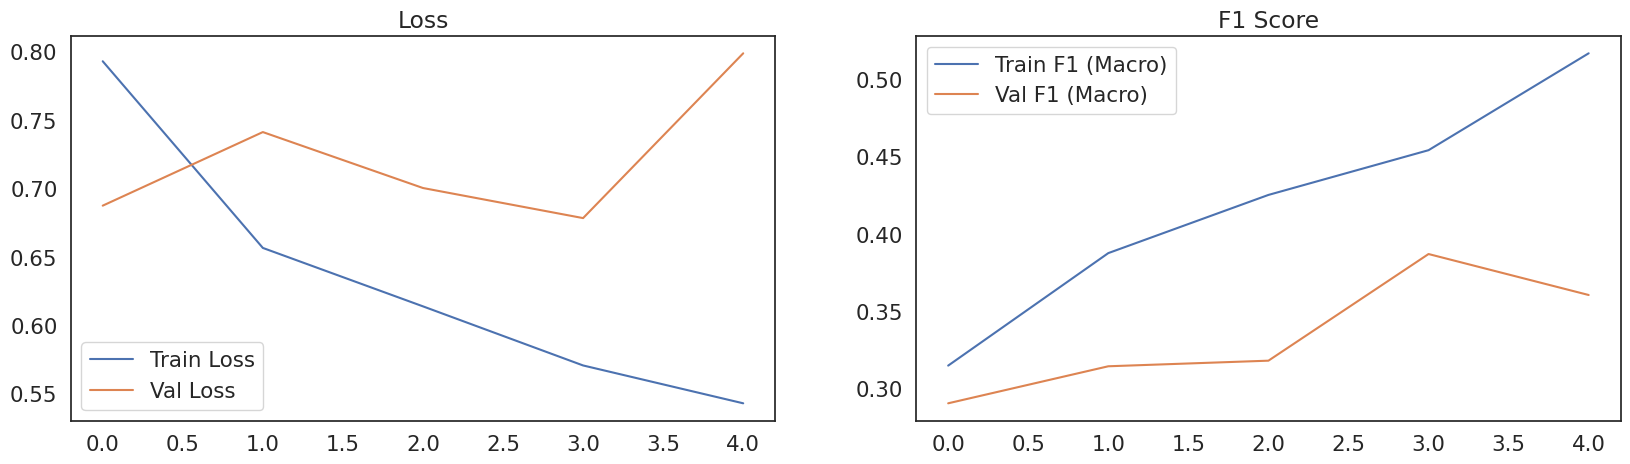

Best Validation F1 Score: 0.3870 at epoch 4


In [227]:
# Plotting results
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_f1'], label='Train F1 (Macro)')
plt.plot(history['val_f1'], label='Val F1 (Macro)')
plt.legend()
plt.title('F1 Score')
plt.show()

print("Best Validation F1 Score: {:.4f} at epoch {}".format(best_val_f1, best_tl_epoch))

### 12.4 Confusion Matrix

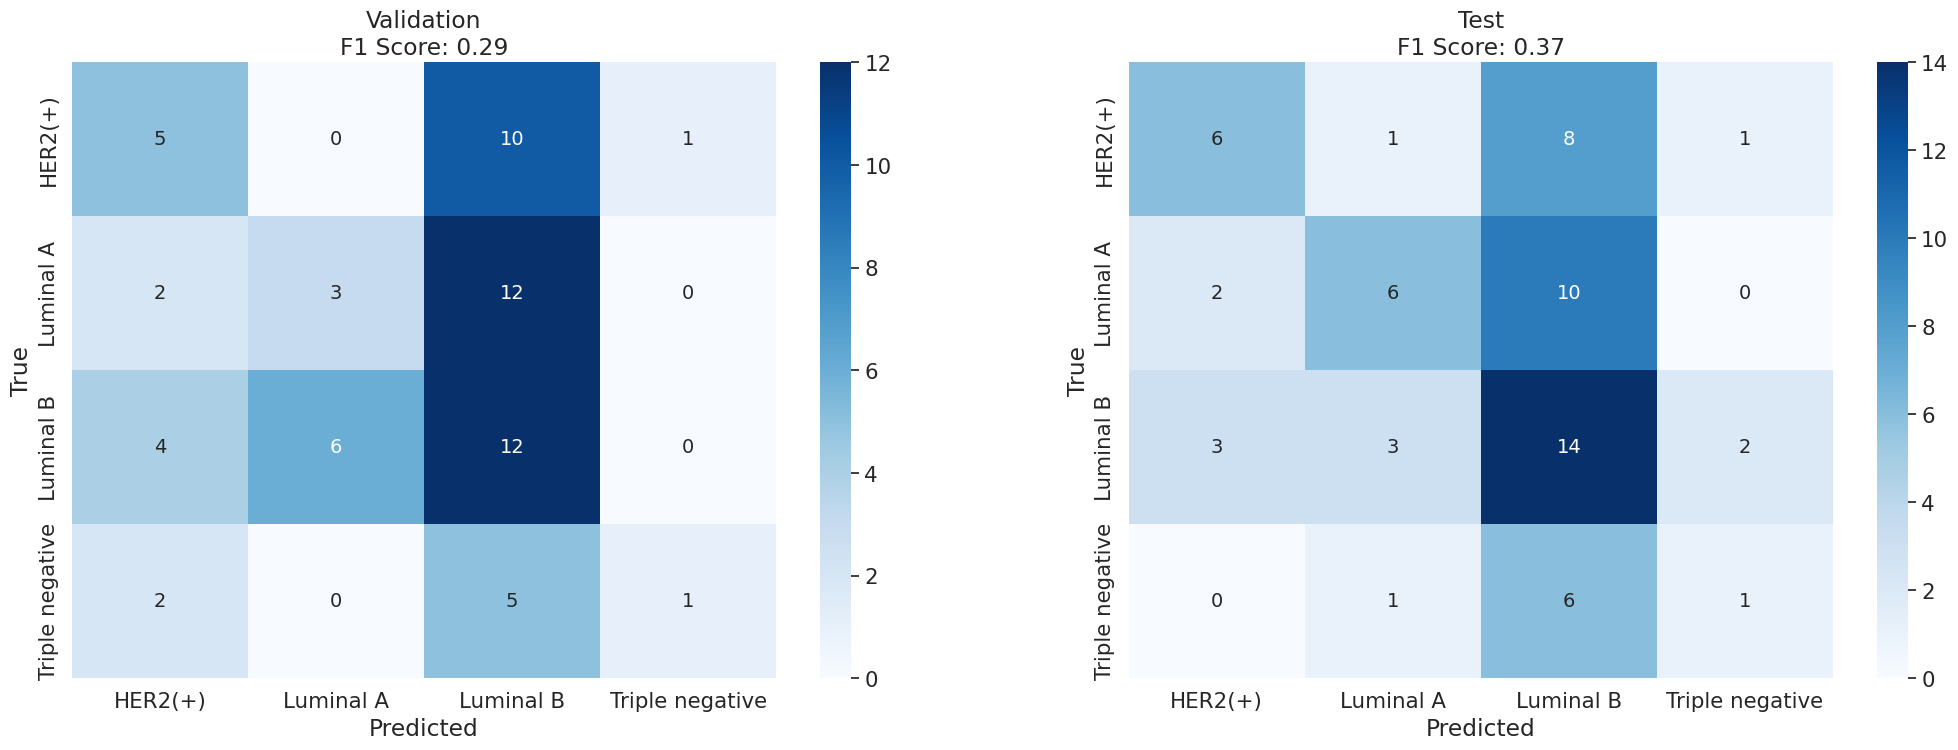

In [ ]:

# 3. Calculate and Plot Confusion Matrix
y_true_img, y_pred_img = get_image_predictions(model, val_loader, device, method="max_mean_confidence")
y_true_img_test, y_pred_img_test = get_image_predictions(model, test_loader, device, method="max_mean_confidence")

# Compute Matrix
cm_val_tl = confusion_matrix(y_true_img, y_pred_img)
cm_test_tl = confusion_matrix(y_true_img_test, y_pred_img_test)
f1_val_tl = f1_score(y_true_img, y_pred_img, average='macro')
f1_test_tl = f1_score(y_true_img_test, y_pred_img_test, average='macro')

# Plotting
plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)
sns.heatmap(cm_val_tl, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Validation\nF1 Score: {f1_val_tl:.2f}')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test_tl, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Test\nF1 Score: {f1_test_tl:.2f}')

plt.show()



Plotting random validation sample with prediction distribution:
Visualizing Sample ID: img_0257 (6 patches)


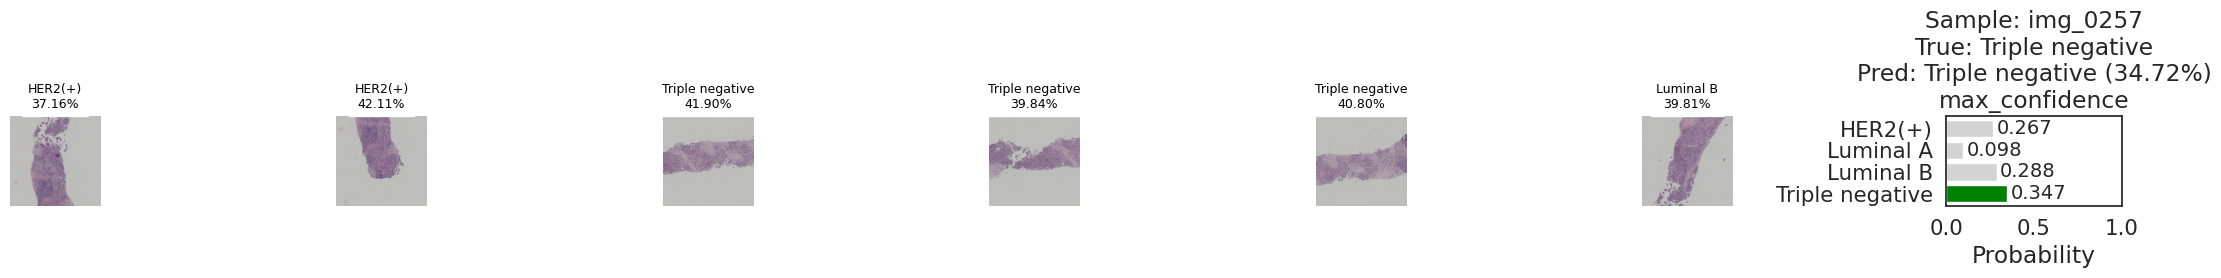

In [229]:
# Visualize a random validation sample
print("Plotting random validation sample with prediction distribution:")
plot_sample_with_predictions(model, val_loader, device, label_encoder, aggregation_method='max_confidence')

## **13. Training Loop: Fine Tuning**

### 13.1 Training

In [230]:
# --- FINE-TUNING PHASE SETUP ---
ft_model = ResNetParallel(num_classes=num_classes, freeze_backbone=True).to(device)

# --- 2. Load the best weights from the first phase ---
ft_model.load_state_dict(torch.load("models/best_model_ResNetParallel_tl.pt"), strict=True)

print(f"Fine-Tuning Configuration:")
print(f" - Image Pillar (ResNet50): Unfreezing last {UNFREEZE_LAYERS_IMG} blocks")
print(f" - Mask Pillar (ResNet18): Unfreezing last {UNFREEZE_LAYERS_MASK} blocks")

# --- 3. Unfreeze parameters ---

# A. Unfreeze the Classifier (Always unfreeze the summit)
for param in ft_model.classifier.parameters():
    param.requires_grad = True

# B. Unfreeze Image Pillar (ResNet50)
if UNFREEZE_LAYERS_IMG > 0:
    # Get the last N children (blocks)
    layers_to_train = list(ft_model.img_encoder.children())[-UNFREEZE_LAYERS_IMG:]
    for block in layers_to_train:
        for param in block.parameters():
            param.requires_grad = True
            
# C. Unfreeze Mask Pillar (ResNet18)
if UNFREEZE_LAYERS_MASK > 0:
    layers_to_train = list(ft_model.mask_encoder.children())[-UNFREEZE_LAYERS_MASK:]
    for block in layers_to_train:
        for param in block.parameters():
            param.requires_grad = True

# --- 4. Optimizer ---
ft_optimizer = torch.optim.RAdam(
    [p for p in ft_model.parameters() if p.requires_grad],
    lr=LR_FT, 
    weight_decay=L2_REG
)
# --- 5. Scheduler ---
ft_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    ft_optimizer, mode='min', factor=0.1, patience=3, 
)


Fine-Tuning Configuration:
 - Image Pillar (ResNet50): Unfreezing last 2 blocks
 - Mask Pillar (ResNet18): Unfreezing last 2 blocks


In [231]:
print_model_stats(ft_model)

Total params: 51,093,316
Trainable params: 34,006,724


In [232]:

print("Starting Fine-Tuning Phase...")

# Reset history
ft_history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}
best_val_f1_ft = 0.0
patience_counter_ft = 0
best_ft_epoch = 0
model_saved = False
ft_better_than_tl = False

# --- 6. Fine-Tuning Loop ---
for epoch in range(NUM_EPOCHS_FT):
    # Train (Pass BOTH criteria)
    train_loss, train_f1 = train_one_epoch(ft_model, train_loader, criterion_cls , ft_optimizer, device)

    # Validate (Pass BOTH criteria)
    val_loss, val_f1 = validate(ft_model, val_loader, criterion_cls, device)

    # Update Scheduler based on Validation Loss
    ft_scheduler.step(val_loss)

    # Store history
    ft_history['train_loss'].append(train_loss)
    ft_history['train_f1'].append(train_f1)
    ft_history['val_loss'].append(val_loss)
    ft_history['val_f1'].append(val_f1)

    # --- Checkpointing & Early Stopping ---
    if val_f1 > best_val_f1_ft:
        best_val_f1_ft = val_f1
        best_ft_epoch = epoch + 1
        patience_counter_ft = 0 
        
        # Save the fine-tuned model
        torch.save(ft_model.state_dict(), 'models/best_model_ResNetParallel_ft.pt')
        model_saved = True
        
        # Check if we beat the Transfer Learning phase
        if best_val_f1_ft > best_val_f1:
            ft_better_than_tl = True
    else:
        model_saved = False
        patience_counter_ft += 1

    # Print Status
    status_mark = "✓" if model_saved else ""
    print(f"FT Epoch {epoch+1}/{NUM_EPOCHS_FT} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter_ft}/{PATIENCE} {status_mark}")

    if patience_counter_ft >= PATIENCE:
        print(f"\nEarly Stopping Triggered! Best FT Epoch: {best_ft_epoch} with Val F1: {best_val_f1_ft:.4f}")
        break

# Final Summary
SUB_MODEL = 'models/best_model_ResNetParallel_ft.pt' if ft_better_than_tl else 'models/best_model_ResNetParallel_tl.pt'
print(f"\nFine-Tuning Complete.")
print(f"Best TL F1: {best_val_f1:.4f}")
print(f"Best FT F1: {best_val_f1_ft:.4f}")
print(f"Best Model Saved to: {SUB_MODEL}")

Starting Fine-Tuning Phase...


FT Epoch 1/200 | Loss: 0.5332 | F1: 0.5059 | Val Loss: 0.6824 | Val F1: 0.3980 | Patience: 0/6 ✓


FT Epoch 2/200 | Loss: 0.5264 | F1: 0.5026 | Val Loss: 0.6819 | Val F1: 0.4067 | Patience: 0/6 ✓


FT Epoch 3/200 | Loss: 0.5077 | F1: 0.5434 | Val Loss: 0.6815 | Val F1: 0.4094 | Patience: 0/6 ✓


FT Epoch 4/200 | Loss: 0.4801 | F1: 0.5727 | Val Loss: 0.6987 | Val F1: 0.4084 | Patience: 1/6 


FT Epoch 5/200 | Loss: 0.4684 | F1: 0.5784 | Val Loss: 0.6869 | Val F1: 0.4015 | Patience: 2/6 


FT Epoch 6/200 | Loss: 0.4436 | F1: 0.5987 | Val Loss: 0.7076 | Val F1: 0.4271 | Patience: 0/6 ✓


FT Epoch 7/200 | Loss: 0.4381 | F1: 0.5963 | Val Loss: 0.7039 | Val F1: 0.4031 | Patience: 1/6 


FT Epoch 8/200 | Loss: 0.4198 | F1: 0.6259 | Val Loss: 0.7020 | Val F1: 0.4050 | Patience: 2/6 


FT Epoch 9/200 | Loss: 0.4044 | F1: 0.6367 | Val Loss: 0.6955 | Val F1: 0.4136 | Patience: 3/6 


FT Epoch 10/200 | Loss: 0.4093 | F1: 0.6492 | Val Loss: 0.6978 | Val F1: 0.4178 | Patience: 4/6 


FT Epoch 11/200 | Loss: 0.4064 | F1: 0.6524 | Val Loss: 0.6965 | Val F1: 0.4194 | Patience: 5/6 


FT Epoch 12/200 | Loss: 0.4077 | F1: 0.6354 | Val Loss: 0.7011 | Val F1: 0.4036 | Patience: 6/6 

Early Stopping Triggered! Best FT Epoch: 6 with Val F1: 0.4271

Fine-Tuning Complete.
Best TL F1: 0.3870
Best FT F1: 0.4271
Best Model Saved to: models/best_model_ResNetParallel_ft.pt


### 13.2 Training History

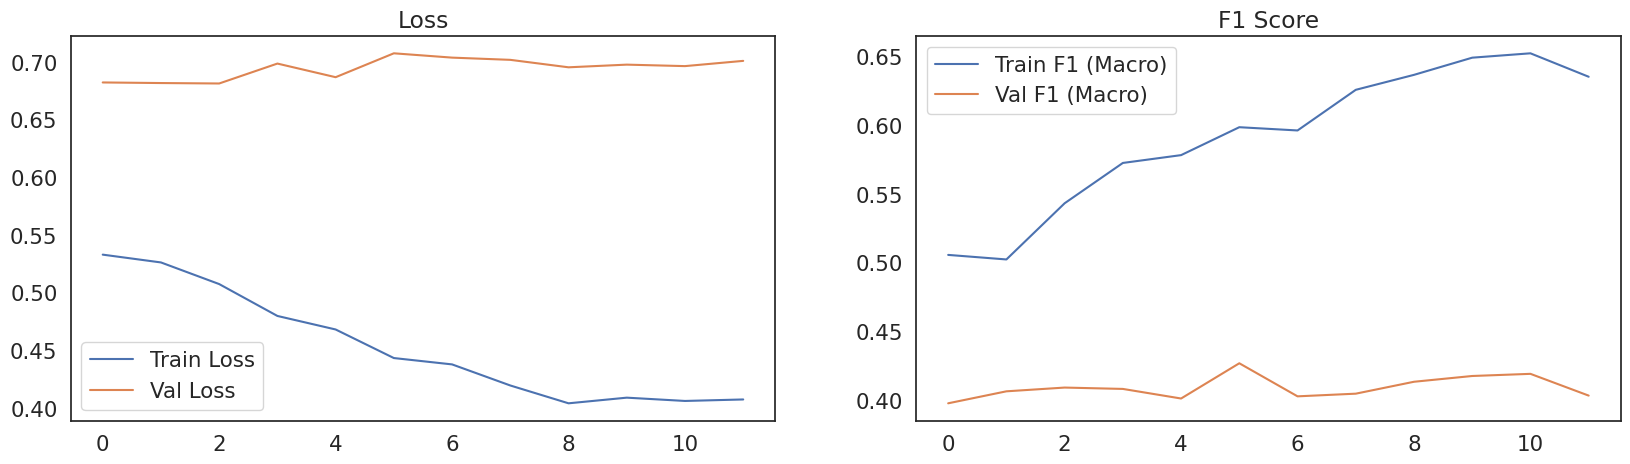

Best Fine-Tuned Validation F1 Score: 0.3870 at epoch 6


In [233]:
# Plotting results
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(ft_history['train_loss'], label='Train Loss')
plt.plot(ft_history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(ft_history['train_f1'], label='Train F1 (Macro)')
plt.plot(ft_history['val_f1'], label='Val F1 (Macro)')
plt.legend()
plt.title('F1 Score')
plt.show()

print("Best Fine-Tuned Validation F1 Score: {:.4f} at epoch {}".format(best_val_f1, best_ft_epoch))

### 13.3 Confusion Matrix

In [254]:
y_true_ft, y_pred_ft = get_image_predictions(ft_model, val_loader, device, method="max_confidence")
y_true_ft_test, y_pred_ft_test = get_image_predictions(ft_model, test_loader, device, method="max_confidence")

cm_val_ft = confusion_matrix(y_true_ft, y_pred_ft)
cm_test_ft = confusion_matrix(y_true_ft_test, y_pred_ft_test)

f1_val_ft = f1_score(y_true_ft, y_pred_ft, average='macro')
f1_test_ft = f1_score(y_true_ft_test, y_pred_ft_test, average='macro')


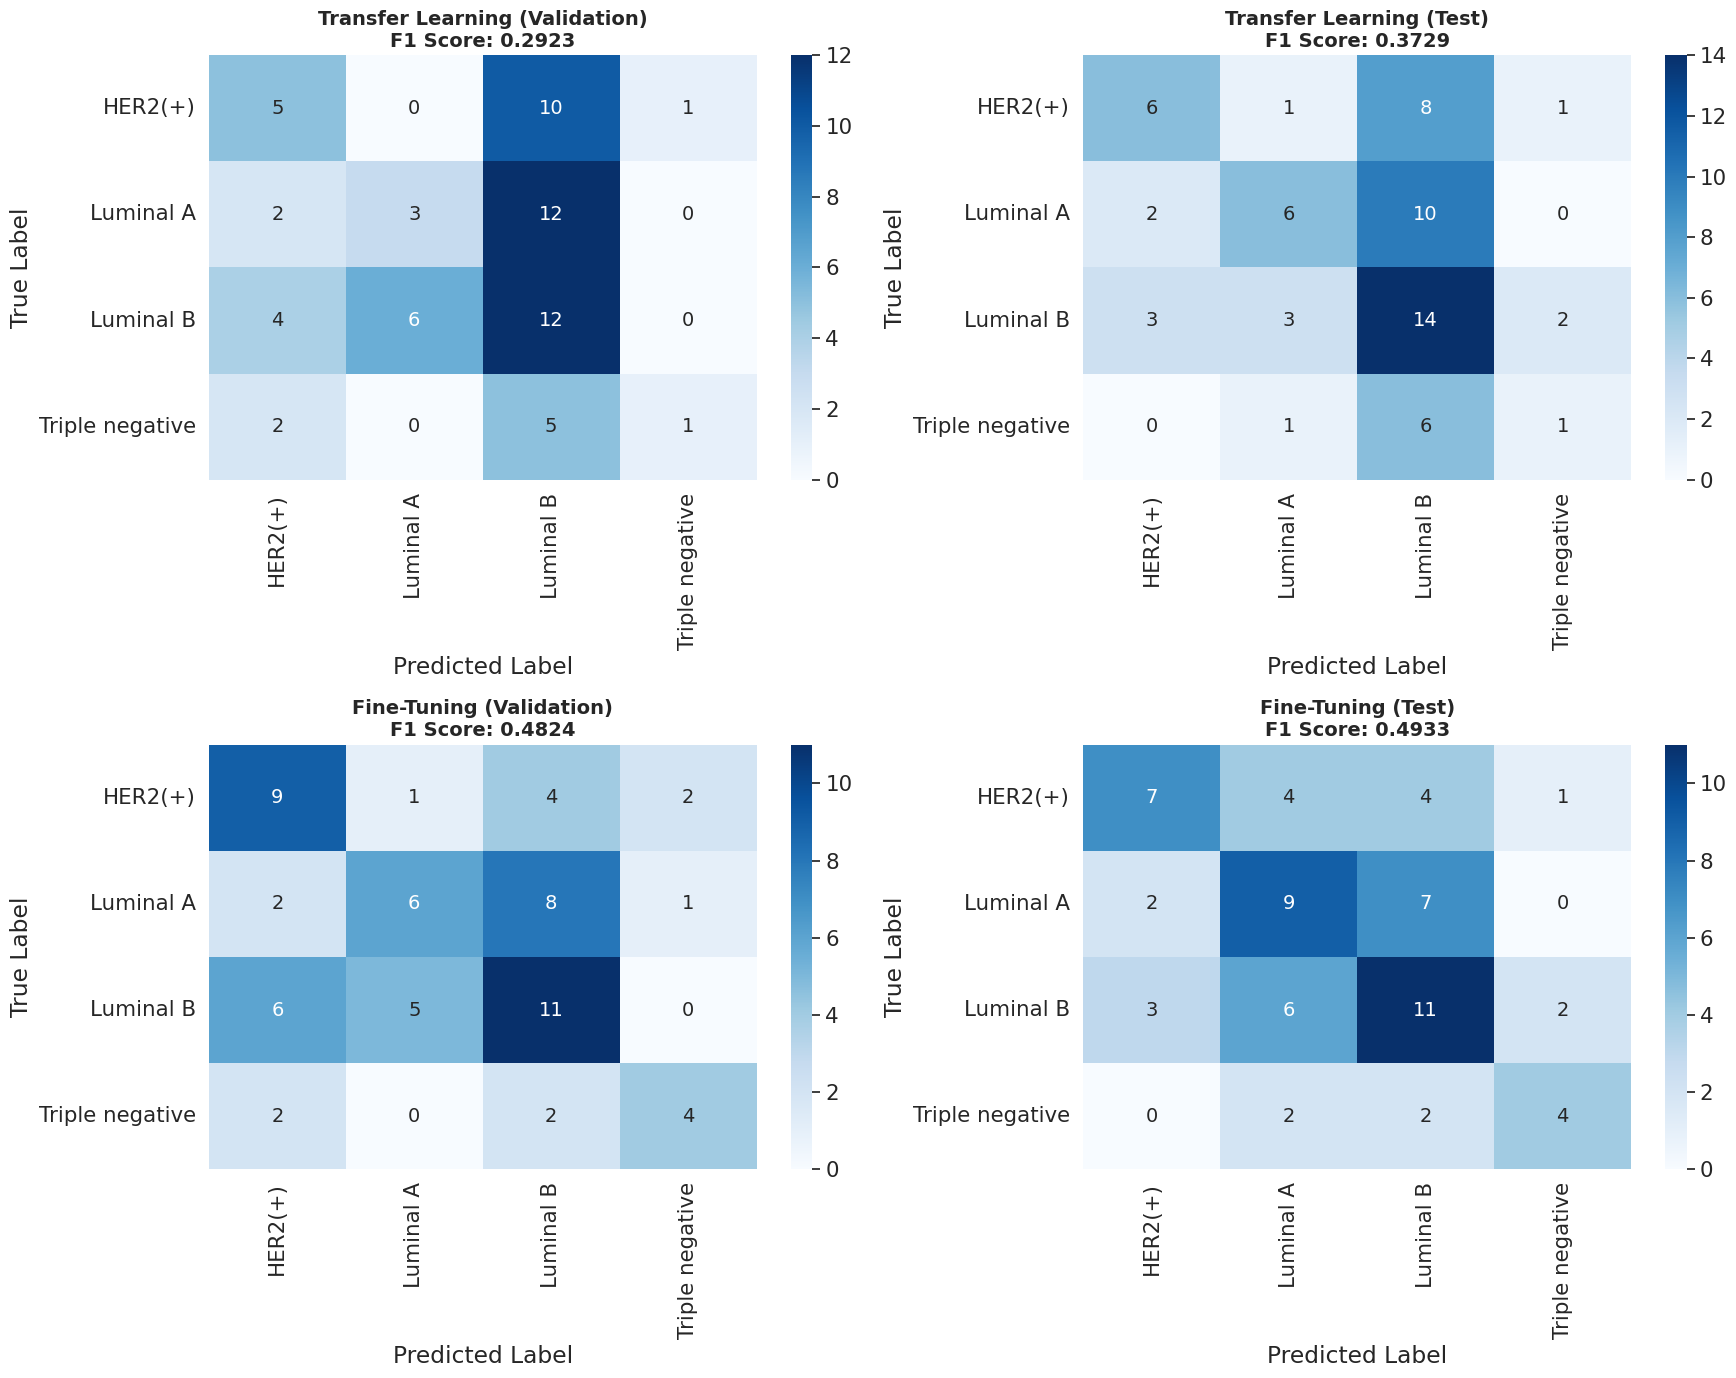

In [235]:
# Create a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()  # Flatten to 1D array for easy iteration

# Prepare data lists for iteration
# Order: T1 Val, T1 Test, FT Val, FT Test
cms = [cm_val_tl, cm_test_tl, cm_val_ft, cm_test_ft]
f1_scores = [f1_val_tl, f1_test_tl, f1_val_ft, f1_test_ft]
titles = [
    "Transfer Learning (Validation)", 
    "Transfer Learning (Test)", 
    "Fine-Tuning (Validation)", 
    "Fine-Tuning (Test)"
]

for i, ax in enumerate(axes):
    sns.heatmap(
        cms[i], 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
        ax=ax
    )
    
    # Set title with F1 score included
    ax.set_title(f"{titles[i]}\nF1 Score: {f1_scores[i]:.4f}", fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

Transfer Learning:
Visualizing Sample ID: img_0146 (4 patches)


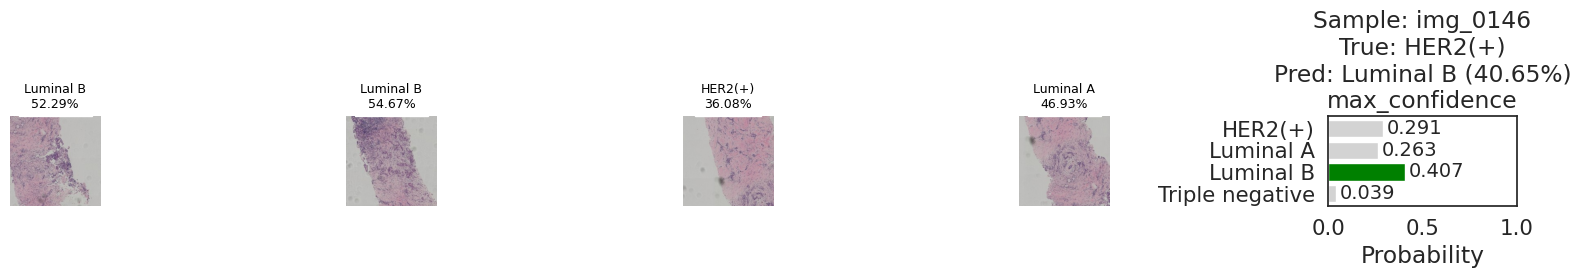

Fine Tuning:
Visualizing Sample ID: img_0146 (4 patches)


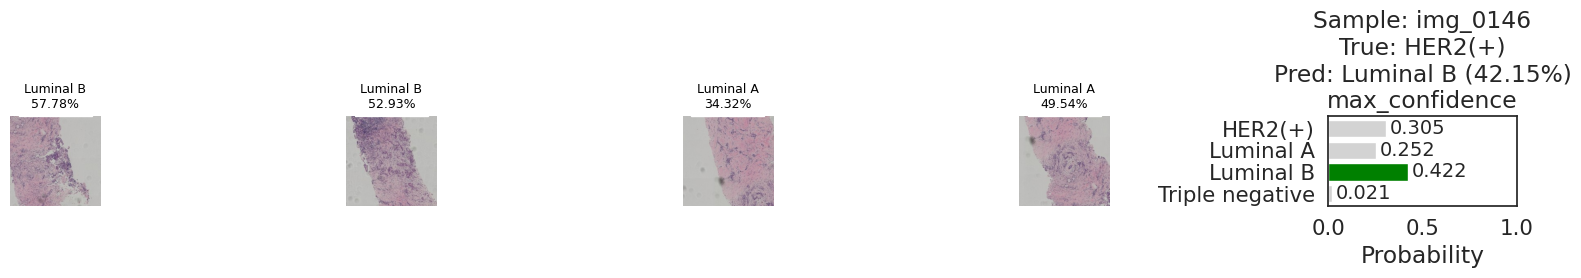

In [236]:
# Visualize a random validation sample
print("Transfer Learning:")
sample_id_plot = np.random.choice(val_loader.dataset.df['sample_id'].unique())
plot_sample_with_predictions(model, val_loader, device, label_encoder, aggregation_method='max_confidence', sample_id=sample_id_plot)
print("Fine Tuning:")
plot_sample_with_predictions(ft_model, val_loader, device, label_encoder, aggregation_method='max_confidence', sample_id=sample_id_plot)

## **14. Class Activation Maps**

### **14.1 Cam Helper Functions**

In [237]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torchvision import transforms
from PIL import Image
import os

# --- 1. Grad-CAM Helper Class ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Hooks
        self.handle_fwd = self.target_layer.register_forward_hook(self.save_activation)
        self.handle_bwd = self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x1, x2, class_idx=None):
        # 1. Forward pass (Pass BOTH inputs: Image + Target)
        output = self.model(x1, x2)
        
        if class_idx is None:
            class_idx = torch.argmax(output)
            
        # 2. Backward pass
        self.model.zero_grad()
        score = output[0, class_idx]
        score.backward()
        
        # 3. Generate CAM
        gradients = self.gradients
        activations = self.activations
        
        if gradients is None or activations is None:
            raise RuntimeError("Hooks failed. Ensure target_layer is visited during forward pass.")

        b, k, u, v = gradients.size()
        
        # Global Average Pooling of Gradients
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        
        # Linear combination
        cam = (weights * activations).sum(1, keepdim=True)
        cam = F.relu(cam) 
        
        # 4. Upsample to image size
        cam = F.interpolate(cam, size=x1.shape[2:], mode='bilinear', align_corners=False)
        
        # 5. Normalize [0, 1]
        cam = cam.view(1, -1)
        cam -= cam.min()
        cam /= (cam.max() + 1e-7)
        cam = cam.view(1, 1, x1.shape[2], x1.shape[3])
        
        return cam.detach().cpu().numpy()[0, 0], output

    def remove_hooks(self):
        self.handle_fwd.remove()
        self.handle_bwd.remove()

# --- 2. Overlay Helper Function ---
def create_heatmap_overlay(cam_map, bg_image_np, alpha=0.6):
    """
    Overlays a CAM heatmap onto a background image (numpy array 0-1).
    """
    # Resize Heatmap to match background
    h, w = bg_image_np.shape[:2]
    heatmap = cv2.resize(cam_map, (w, h))
    
    # Colorize Heatmap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_colored = np.float32(heatmap_colored) / 255.0

    # Blend
    overlay = (alpha * heatmap_colored) + ((1 - alpha) * bg_image_np)
    overlay = overlay / np.max(overlay) 
    
    return overlay

# --- 3. Main Visualization Function (Paired Image Updated) ---
def visualize_sample_analysis(model, df_metadata, sample_id, label_encoder, device, target_dir=None):
    """
    Visualizes analysis for a sample using the Two-Stream (Paired Image) Model.
    Args:
        model: The trained Two-Stream model.
        df_metadata: The pandas DataFrame.
        sample_id: The ID of the sample.
        label_encoder: The encoder used for labels.
        device: 'cuda' or 'cpu'.
        target_dir: (Optional) Path to the folder containing the second images.
    """
    model.eval()
    
    # --- 1. Filter DataFrame directly ---
    sample_rows = df_metadata[df_metadata['sample_id'] == sample_id]
    
    if len(sample_rows) == 0:
        print(f"Sample {sample_id} not found in the provided DataFrame.")
        return

    # --- 2. Define Transforms ---
    # Apply SAME transform to both images
    img_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Inverse Normalize (for display)
    inv_normalize = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                             std=[1/0.229, 1/0.224, 1/0.225])
    ])

    # --- 3. Batch Inference ---
    patch_probs = []
    patch_data = [] 
    
    # Target Layer Selection (Bottleneck of Image Encoder)
    try:
        target_layer = model.img_encoder[-2][-1] 
    except:
        target_layer = list(model.img_encoder.children())[-2]

    grad_cam = GradCAM(model, target_layer)
    
    print(f"Processing sample {sample_id} with {len(sample_rows)} patches...")
    
    for _, row in sample_rows.iterrows():
        try:
            # --- Load Input Image ---
            img_path = row['path']
            img_pil = Image.open(img_path).convert('RGB')
            img_tensor = img_transform(img_pil).unsqueeze(0).to(device)
            
            # --- Load Target Image (Second Image) ---
            target_pil = Image.new('RGB', (224, 224), (0, 0, 0))
            if target_dir:
                fname = os.path.basename(img_path)
                # Look for EXACT filename in target dir
                target_path = os.path.join(target_dir, fname)
                
                if os.path.exists(target_path):
                    target_pil = Image.open(target_path).convert('RGB')
            
            target_tensor = img_transform(target_pil).unsqueeze(0).to(device)
            
            patch_data.append({
                'img_tensor': img_tensor, 
                'target_tensor': target_tensor, 
                'path': row['path']
            })
            
            with torch.no_grad():
                outputs = model(img_tensor, target_tensor)
                probs = F.softmax(outputs, dim=1)
                patch_probs.append(probs.cpu().numpy())
                
        except Exception as e:
            # print(f"Skipping patch: {e}")
            continue

    if not patch_probs:
        print("No valid patches found.")
        grad_cam.remove_hooks()
        return

    patch_probs = np.vstack(patch_probs)
    avg_probs = np.mean(patch_probs, axis=0) 
    
    classes = label_encoder.classes_
    pred_class_idx = np.argmax(avg_probs)
    pred_label = classes[pred_class_idx]
    
    # Get True Label
    if 'label_encoded' in sample_rows.columns:
        true_label_idx = sample_rows.iloc[0]['label_encoded']
        true_label = label_encoder.inverse_transform([true_label_idx])[0]
    else:
        true_label = "Unknown"
    
    # --- 4. Select Best Patch ---
    # We select the patch that had the highest confidence for the predicted class
    best_patch_idx = np.argmax(patch_probs[:, pred_class_idx])
    best_data = patch_data[best_patch_idx]
    
    # Prepare active tensors for GradCAM
    img_tensor_active = best_data['img_tensor'].clone().detach()
    target_tensor_active = best_data['target_tensor'].clone().detach()
    
    img_tensor_active.requires_grad = True 
    # Note: If you want GradCAM on the target encoder, you'd need hooks there too.
    # Currently, we are visualizing which parts of Input 1 were important.

    # --- 5. Generate GradCAM ---
    # A. Predicted Class CAM
    pred_cam_mask, _ = grad_cam(img_tensor_active, target_tensor_active, pred_class_idx)
    
    # Display Images (Denormalized)
    # Image 1
    img_display = inv_normalize(best_data['img_tensor'][0]).cpu().detach().numpy()
    img_display = np.transpose(img_display, (1, 2, 0))
    img_display = np.clip(img_display, 0, 1)
    
    # Image 2 (Target)
    target_display = inv_normalize(best_data['target_tensor'][0]).cpu().detach().numpy()
    target_display = np.transpose(target_display, (1, 2, 0))
    target_display = np.clip(target_display, 0, 1)

    # Create Overlays
    # Overlay on Input Image
    cam_on_image = create_heatmap_overlay(pred_cam_mask, img_display)
    
    # Overlay on Target Image (Shows correlation location if target has spatial correspondence)
    cam_on_target = create_heatmap_overlay(pred_cam_mask, target_display)

    # B. Other Classes CAMs (Optional: see why it didn't pick others)
    other_indices = [i for i in range(len(classes)) if i != pred_class_idx]
    cam_others_overlays = {}
    
    for i in other_indices:
        img_tensor_active.grad = None 
        mask_map, _ = grad_cam(img_tensor_active, target_tensor_active, i)
        overlay = create_heatmap_overlay(mask_map, img_display)
        cam_others_overlays[i] = overlay
        
    grad_cam.remove_hooks() 

    # --- 6. Plotting ---
    fig = plt.figure(figsize=(24, 10))
    gs = gridspec.GridSpec(2, max(4, len(other_indices) + 1), height_ratios=[1.2, 0.8])

    # --- Row 1: Prediction Analysis ---
    
    # 1. Original Input Image
    ax0 = plt.subplot(gs[0, 0])
    ax0.imshow(img_display)
    ax0.set_title(f"Best Patch (Input)\nTrue: {true_label}", fontsize=12, fontweight='bold')
    ax0.axis('off')

    # 2. Focus on Input Image
    ax1 = plt.subplot(gs[0, 1])
    ax1.imshow(cam_on_image)
    ax1.set_title(f"Focus (Input): {pred_label}\n({avg_probs[pred_class_idx]:.1%})", fontsize=12, fontweight='bold', color='darkblue')
    ax1.axis('off')
    
    # 3. Focus on Target Image
    ax2 = plt.subplot(gs[0, 2])
    ax2.imshow(cam_on_target)
    ax2.set_title(f"Focus (2nd Img)", fontsize=12, fontweight='bold')
    ax2.axis('off')

    # 4. Bar Chart Stats
    ax3 = plt.subplot(gs[0, 3])
    colors = ['#d3d3d3'] * len(classes)
    colors[pred_class_idx] = '#4CAF50' if pred_label == true_label else '#F44336'
    
    bars = ax3.bar(classes, avg_probs, color=colors, alpha=0.85, edgecolor='black')
    ax3.set_title(f"Sample ID: {sample_id}", fontsize=12, fontweight='bold')
    ax3.set_ylim(0, 1.05)
    
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.1%}', ha='center', va='bottom', fontsize=10)

    # --- Row 2: Analysis of Other Classes (Counterfactuals) ---
    if other_indices:
        for idx, class_idx in enumerate(other_indices):
            ax = plt.subplot(gs[1, idx])
            overlay = cam_others_overlays[class_idx]
            
            ax.imshow(overlay)
            class_name = classes[class_idx]
            ax.set_title(f"Evidence for: {class_name}\n({avg_probs[class_idx]:.1%})", fontsize=10)
            ax.axis('off')
    else:
        # Just show empty plot if binary
        ax = plt.subplot(gs[1, 0])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

### **14.2 CAM Visualization**

Processing sample img_0593 with 7 patches...


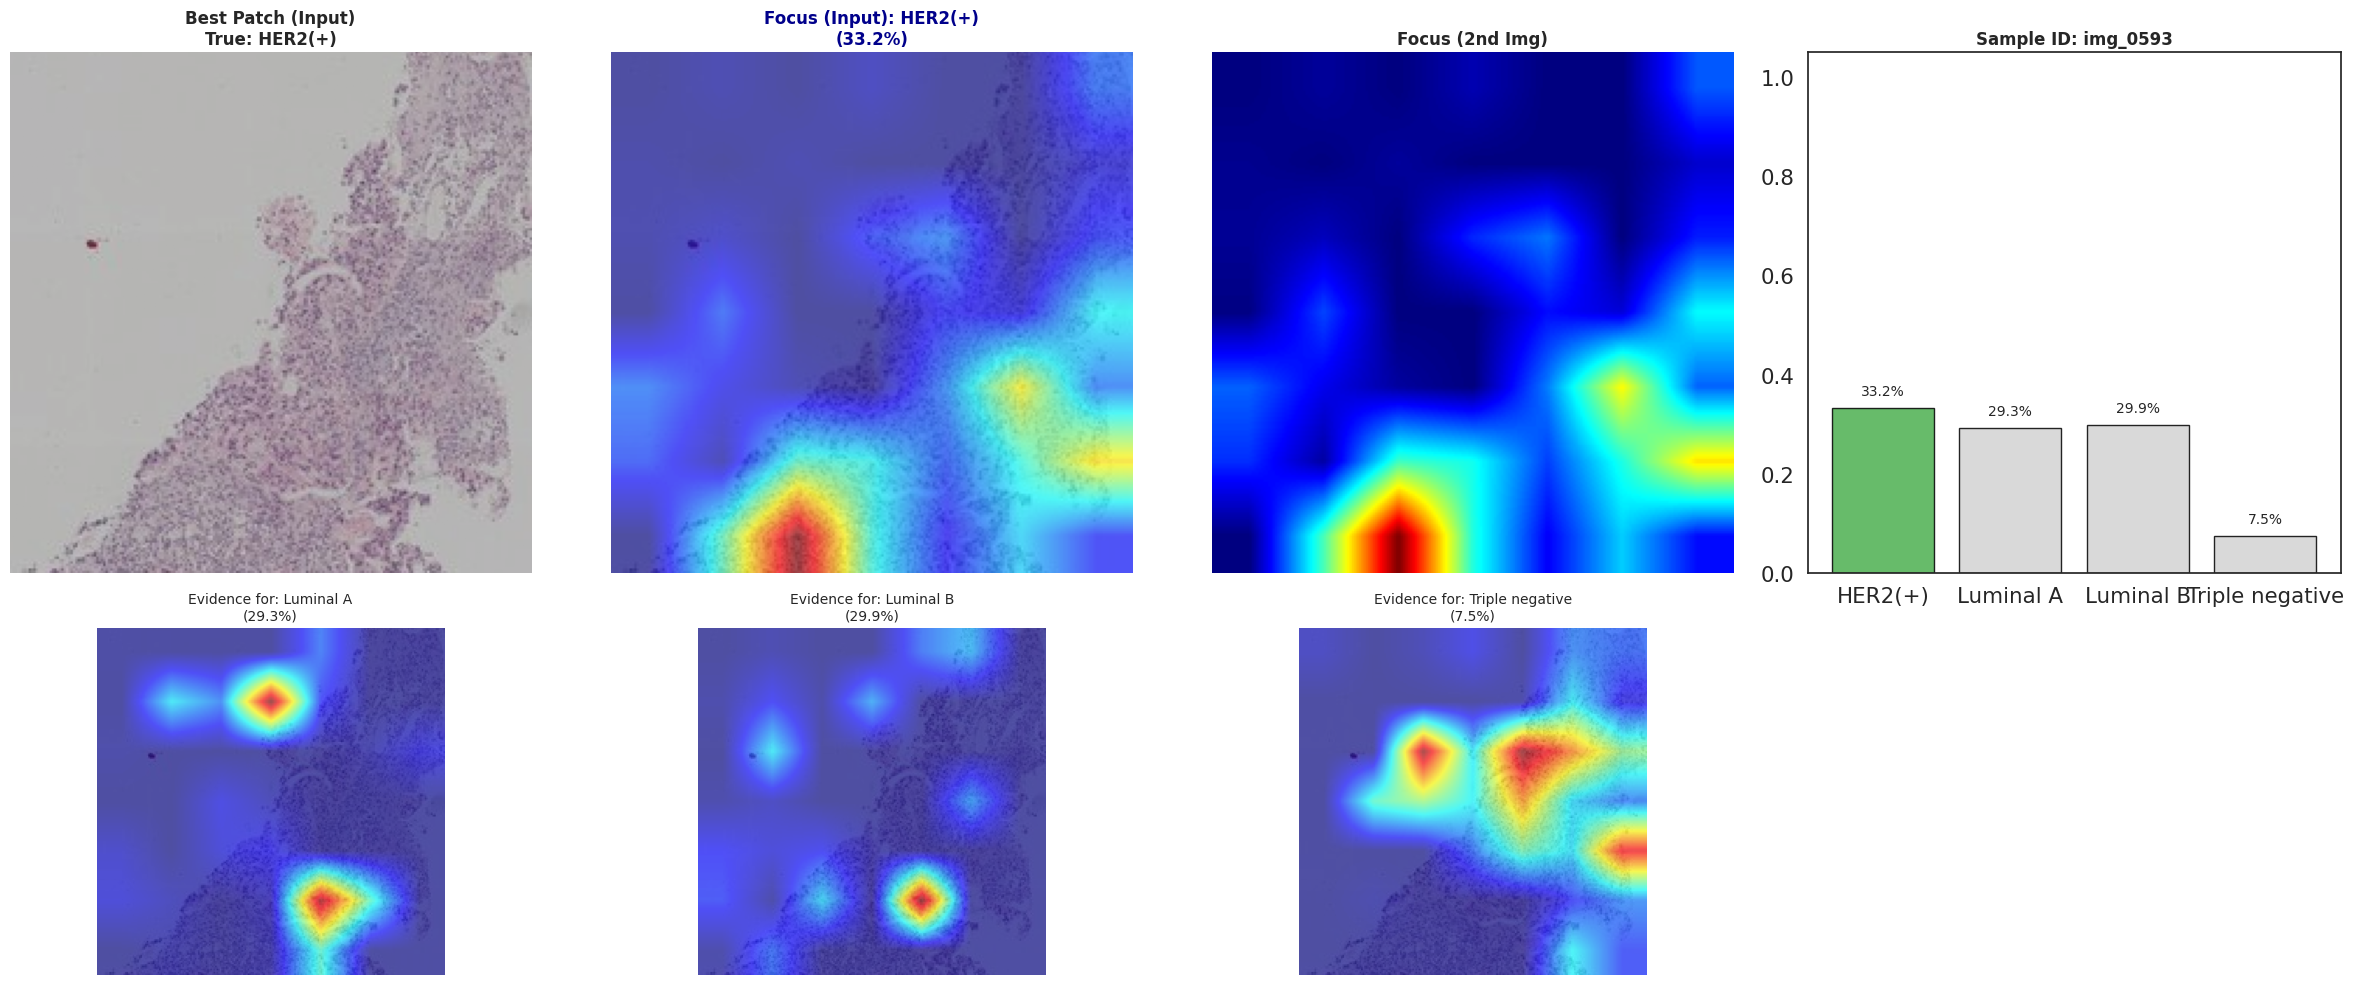

TypeError: visualize_sample_analysis() got an unexpected keyword argument 'masks_dir'

In [ ]:
# Select a sample ID from your validation set
if SUB_MODEL is None:
    SUB_MODEL = 'models/best_model_ResNetMTL_tl.pt'  # Default to TL model if none specified
PATCH_MASKS_DIR = os.path.join(datasets_path, "preprocessing_results","train_patches","masks")
cam_model = ResNetParallel(num_classes, freeze_backbone=True).to(device)
cam_model.load_state_dict(torch.load(SUB_MODEL), strict=True)
cam_idx = random.randint(0, len(df_val['sample_id'].unique()) - 1)
sample_id_to_test = df_val['sample_id'].iloc[cam_idx] 
visualize_sample_analysis(cam_model, patches_metadata_df, sample_id_to_test, label_encoder, device)
visualize_sample_analysis(cam_model, patches_metadata_df, sample_id_to_test, label_encoder, device, target_dir=PATCH_MASKS_DIR)

## **14. Submission Creation**

### 14.1 Create Submission Model

In [239]:
sub_model = ResNetParallel(num_classes, freeze_backbone=True).to(device)

# 2. Load the best weights from the training
sub_model.load_state_dict(torch.load(SUB_MODEL), strict=True)
print(f"Submodel loaded from {SUB_MODEL} for final evaluation.")


Submodel loaded from models/best_model_ResNetParallel_ft.pt for final evaluation.


### 14.2 Define Transform

In [240]:
# Define Validation Transform (Compatible with V2 or Standard)
val_transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(), # Robust standard equivalent to ToImage + ToDtype
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])


### 14.3 Function: Submission CSV

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision import transforms

def generate_submission(model, submission_folder, label_encoder, target_folder=None, method='max_confidence', output_csv="submission.csv", device='cuda'):
    """
    Generates a submission file for the Paired Image (Two-Stream) model.
    Args:
        model: Trained TwoStream/ResNetParallel model.
        submission_folder: Folder containing test patch images (Input 1).
        label_encoder: The LabelEncoder object used during training to decode predictions.
        target_folder: (Optional) Folder containing corresponding second images (Input 2).
                       If None, uses black images.
    """
    model.eval()
    model.to(device) # Ensure model is on the correct device

    # 1. Get list of test patches
    patch_files = sorted([f for f in os.listdir(submission_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    print(f"Found {len(patch_files)} patches in {submission_folder}")
    if target_folder:
        print(f"Looking for second images in: {target_folder}")
    else:
        print("No target folder provided. Using black images (Single Stream Mode).")

    # 2. Define Transforms (Must match training validation transforms)
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Store predictions per image
    image_predictions = {}
    missing_targets_count = 0

    print("Running inference...")
    with torch.no_grad():
        for filename in tqdm(patch_files):
            filepath = os.path.join(submission_folder, filename)

            try:
                # --- ID Extraction ---
                # Extracts "img_123" from "img_123_patch_0.png" or "img_123_p1.png"
                if '_p' in filename:
                    sample_id = filename.rsplit('_p', 1)[0]
                elif '_patch' in filename:
                    sample_id = filename.rsplit('_patch', 1)[0]
                else:
                    # Fallback for whole images
                    sample_id = os.path.splitext(filename)[0]

                if sample_id not in image_predictions:
                    image_predictions[sample_id] = {'probs': []}

                # --- A. Load Input Image ---
                image = Image.open(filepath).convert('RGB')
                input_tensor = val_transform(image).unsqueeze(0).to(device)

                # --- B. Load Second Image (Target) ---
                # Default: Black RGB image
                target_pil = Image.new('RGB', image.size, (0, 0, 0))
                
                if target_folder:
                    # Look for the EXACT same filename in the target folder
                    target_path = os.path.join(target_folder, filename)
                    
                    if os.path.exists(target_path):
                        target_pil = Image.open(target_path).convert('RGB')
                    else:
                        missing_targets_count += 1
                
                # Apply normalization to target as well
                target_tensor = val_transform(target_pil).unsqueeze(0).to(device)

                # --- C. Model Inference ---
                # Pass BOTH tensors (RGB + RGB) to the model
                logits = model(input_tensor, target_tensor)
                
                # Softmax to get probabilities
                probs = torch.softmax(logits, dim=1)

                image_predictions[sample_id]['probs'].append(probs.cpu().numpy()[0])

            except Exception as e:
                print(f"Error processing {filename}: {e}")
                pass
    
    if target_folder and missing_targets_count > 0:
        print(f"WARNING: Could not find paired images for {missing_targets_count} patches.")

    # 3. Aggregate Results
    final_results = []

    print(f"Aggregating results for {len(image_predictions)} unique samples...")

    for sample_id, data in image_predictions.items():
        all_probs = np.array(data['probs']) 

        # Construct sample name (adjust extension if needed, e.g. .tif or .png)
        # If your submission file requires IDs like "10045", remove the extension part below.
        sample_index_name = f"{sample_id}.png"

        if len(all_probs) == 0:
            # Fallback (should not happen if loop ran)
            final_results.append({'sample_index': sample_index_name, 'label': "Luminal A"}) 
            continue

        if method == 'majority_voting':
            patch_preds = np.argmax(all_probs, axis=1)
            counts = np.bincount(patch_preds)
            final_class_idx = np.argmax(counts)

        elif method == 'max_mean_confidence':
            # Average the probabilities across all patches for this slide
            avg_probs = np.mean(all_probs, axis=0)
            final_class_idx = np.argmax(avg_probs)
        elif method == 'max_confidence':

            # Average the probabilities across all patches for this slide
            final_class_idx = np.argmax(all_probs.max(axis=0))

        # Decode Label using the PASSED label_encoder
        pred_label = label_encoder.inverse_transform([final_class_idx])[0]
        final_results.append({'sample_index': sample_index_name, 'label': pred_label})

    # 4. Save
    df_submission = pd.DataFrame(final_results)
    
    if 'sample_index' in df_submission.columns:
        df_submission.sort_values('sample_index', inplace=True)
    
    df_submission.to_csv(output_csv, index=False)

    print(f"Submission saved to {output_csv}")

    return df_submission

In [277]:
def plot_submission_distribution(submission_data, output_file="prediction_distribution.png", ax=None):
    """
    Plots the distribution of predicted labels.

    Args:
        submission_data: DataFrame or path to csv.
        output_file: Path to save the plot (only used if ax is None).
        ax: Matplotlib axes object. If None, a new figure is created.
    
    Returns:
        ax: The matplotlib Axes object.
    """
    # 1. Load Data
    if isinstance(submission_data, str):
        if not os.path.exists(submission_data):
            print(f"Error: File {submission_data} not found.")
            return None
        df = pd.read_csv(submission_data)
    elif isinstance(submission_data, pd.DataFrame):
        df = submission_data
    else:
        raise ValueError("Input must be a pandas DataFrame or a file path string.")

    if 'label' not in df.columns:
        print("Error: DataFrame must contain a 'label' column.")
        return None

    # 2. Setup Plot Style
    sns.set_theme(style="whitegrid")
    
    # Check if external axes provided
    is_standalone = False
    if ax is None:
        is_standalone = True
        fig, ax = plt.subplots(figsize=(10, 6))

    # 3. Create Count Plot
    order = df['label'].value_counts().index
    sns.countplot(x='label', data=df, order=order, palette="viridis", hue='label', legend=False, ax=ax)

    # 4. Add Annotations
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        if height > 0: # Check to avoid errors with empty bars
            percentage = '{:.1f}%'.format(100 * height / total)
            ax.annotate(f'{int(height)}\n({percentage})',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', 
                        fontsize=11, color='black', xytext=(0, 5),
                        textcoords='offset points')

    # 5. Formatting
    ax.set_title(f'Prediction Distribution (N={total})', fontsize=15, fontweight='bold')
    ax.set_xlabel('Predicted Class', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x', rotation=45)

    # 6. Save and Show (Only if standalone)
    if is_standalone:
        plt.tight_layout()
        plt.show()

    return ax

### 14.3 Create the Submission CSV

In [ ]:
now = datetime.now()
date_time_str = now.strftime("%d_%b-%H_%M")

sub_dir = os.path.join(os.path.pardir, "submission_csvs")
OUTPUT_NAME = os.path.join(sub_dir, f"submission_ft--{date_time_str}.csv")


os.makedirs(sub_dir, exist_ok=True)

# Check if folder exists
if os.path.exists(SUBMISSION_PATCHES_OUT):
    # Method 1: Max Confidence / Average Probability (Recommended)
    df_sub_max_conf = generate_submission(sub_model, SUBMISSION_PATCHES_OUT,label_encoder=label_encoder, target_folder=BLURRED_PATCHES_OUT, method='max_mean_confidence', output_csv=OUTPUT_NAME)
    print(f"Submission CSV saved to: {OUTPUT_NAME}")

    # Method 2: Majority Voting (Optional, uncomment to run)
    # df_sub_majority_voting = generate_submission(sub_model, SUBMISSION_PATCHES_OUT, method='majority_voting', output_csv="submission_voting.csv")
else:
    print(f"Directory '{SUBMISSION_PATCHES_OUT}' not found. Please create it or set the correct path.")

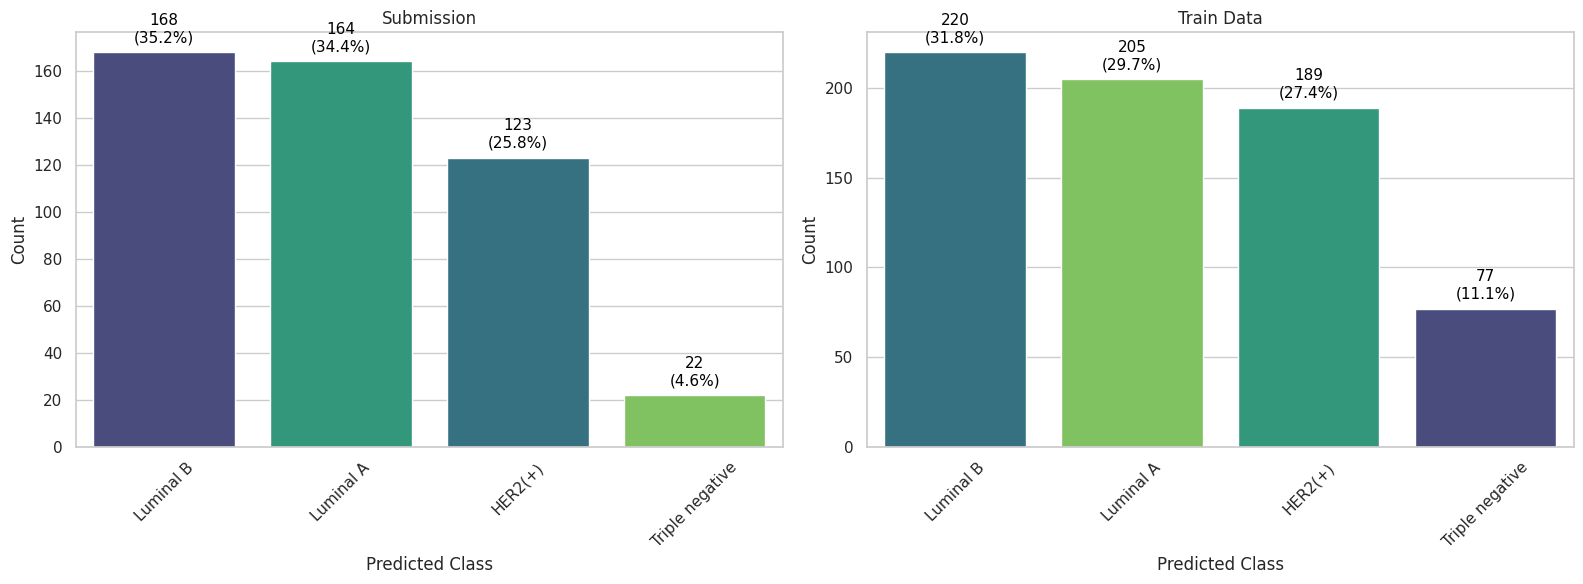

In [279]:

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot on specific axes
plot_submission_distribution(df_sub_max_conf, ax=axes[0])
axes[0].set_title("Submission") # Override title if desired

plot_submission_distribution(CSV_PATH, ax=axes[1])
axes[1].set_title("Train Data")

plt.tight_layout()
plt.show()